# Модель классификации комментариев на позитивные и негативные с BERT

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В распоряжении есть набор данных с разметкой о токсичности правок.

Нужно построить модель со значением метрики качества *F1* не меньше 0.75. 

**План выполнения проекта:**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. Целевая метрика *F1* не меньше 0.75.
3. Сделайте выводы.

**Описание данных**  
Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import re
import torch
import transformers as ppb
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import f1_score 
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from pathlib import Path
import time
from tqdm import notebook
from tqdm import tqdm
tqdm.pandas()
import torch.nn as nn
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW
import sys
import spacy 
nltk.tokenize.word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize 
from nltk.tokenize import word_tokenize 
import nltk
nltk.download('averaged_perceptron_tagger')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


**Загрузим датасет и посмотрим**

In [2]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')

except BaseException:
    df = pd.read_csv('C:/Users/HP/Downloads/toxic_comments.csv')
df

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
df.duplicated().sum()

0

In [5]:
df.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

**Посмотрим соотношение классов:** явный дисбаланс классов - 90/10

0    0.898388
1    0.101612
Name: toxic, dtype: float64

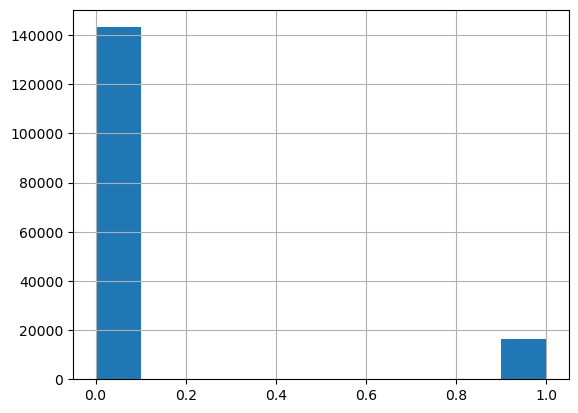

In [6]:
df['toxic'].hist()
df['toxic'].value_counts(normalize= True)

---

###  Проведем подготовку признаков для обучения

In [8]:
lemmatizer = WordNetLemmatizer()

In [9]:
def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize_sent(text): 
    return [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]  


def lemmatize_text(text):
    lemm_text = " ".join(lemmatize_sent(text))
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    corpys = " ".join(cleared_text.split())
    return corpys

In [10]:
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])

In [11]:
df_my['lemm_text'] = df_my['text'].apply(lemmatize_text)
print('Изначальный текст:', df_my['text'])
print()
print('Лемматизированный текст:', df_my['lemm_text'])

Изначальный текст: 0    The striped bats are hanging on their feet for...
1        you should be ashamed of yourself went worked
Name: text, dtype: object

Лемматизированный текст: 0    the striped bat be hang on their foot for best
1         you should be ashamed of yourself go work
Name: lemm_text, dtype: object


In [12]:
df['lemm_text'] = df['text'].progress_apply(lemmatize_text)

100%|██████████| 159292/159292 [11:43<00:00, 226.29it/s]


In [13]:
df['lemm_text']

0         explanation why the edits make under my userna...
1         d aww he match this background colour i m seem...
2         hey man i m really not try to edit war it s ju...
3         more i ca n t make any real suggestion on impr...
4         you sir be my hero any chance you remember wha...
                                ...                        
159287    and for the second time of ask when your view ...
159288    you should be ashamed of yourself that be a ho...
159289    spitzer umm theres no actual article for prost...
159290    and it look like it be actually you who put on...
159291    and i really do n t think you understand i com...
Name: lemm_text, Length: 159292, dtype: object

In [14]:
df

,Unnamed: 0,text,toxic,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i ca n t make any real suggestion on impr...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...
159288,159447,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm theres no actual article for prost...
159290,159449,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


Так как целевой признак разбаланисрован, при разделении на подвыборки с помощью train_test_split() используем аргумент  stratify который при разделении сохранит сооотношение классов в подвыборках.

In [15]:
target = df['toxic']
features = df['lemm_text']

features_train, features_tv, target_train, target_tv = train_test_split(
    features, target, test_size=0.4, random_state=1234567, stratify= target)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_tv, target_tv, test_size=0.5, random_state=1234567, stratify= target_tv)

Проверим размерность подвыборок и переведем в нужный формат

In [16]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(95575,)
(95575,)
(31859,)
(31859,)
(31858,)
(31858,)


Вектаризируем токены и удалим стоп-слова.

In [17]:
stop = list(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=(stop))

In [18]:
features_train_tfidf = count_tf_idf.fit_transform(features_train)
features_valid_tfidf = count_tf_idf.transform(features_valid)
features_test_tfidf = count_tf_idf.transform(features_test)
print(features_train_tfidf.shape)
print(features_valid_tfidf.shape)
print(features_test_tfidf.shape)

(95575, 116564)
(31859, 116564)
(31858, 116564)


**Вывод:**  
- Объем строк датафрейма 159 292.
- Дубликатов и пропусков нет.
- Дисбаланс классов - 90/10
- Проведена лемматицация теста в столбце text в столбец lemm_text.
- Удалены стоп слова.
- Слова векторизированы через TfidfVectorizer.
- Выборка разделена на обучающую, валидационнную и тестовую в соотношении: 60/20/20.  

Данные готовы к обучению.

---

## Обучение

### Линейная регрессия

In [19]:
model_lg = LogisticRegression(random_state=1234567, solver='liblinear', max_iter=1000, class_weight = 'balanced', C = 10)
model_lg.fit(features_train_tfidf, target_train) 
predict_val = model_lg.predict(features_valid_tfidf)
f1_sc = f1_score(target_valid, predict_val)
print("f1_score модели Логистическая регрессия:", f1_sc.round(4))

f1_score модели Логистическая регрессия: 0.7539


### Дерево решений

In [20]:
best_f1_sc = 0
best_depth = 0
for depth in notebook.tqdm(range(1, 21)):
    model_dtc = DecisionTreeClassifier(random_state=1234567, max_depth=depth, class_weight = 'balanced')
    model_dtc.fit(features_train_tfidf, target_train)
    predict_val_dct = model_dtc.predict(features_valid_tfidf)
    f1_sc_dtc = f1_score(target_valid, predict_val_dct)
    if f1_sc_dtc > best_f1_sc:
            best_f1_sc = f1_sc_dtc
            best_depth = depth
print("f1_score наилучшей модели на валидационной выборке:", best_f1_sc.round(2))
print("Количество ветвей модели на валидационной выборке:", best_depth)

  0%|          | 0/20 [00:00<?, ?it/s]

f1_score наилучшей модели на валидационной выборке: 0.6
Количество ветвей модели на валидационной выборке: 17


### BERT

Для BERT выборки подготовим отдельно. Чтобы ускорить обчение, уменьшу выборку по 1000 сток.

In [21]:
df_smal = df.sample(1000).reset_index(drop=True)

0    0.882
1    0.118
Name: toxic, dtype: float64

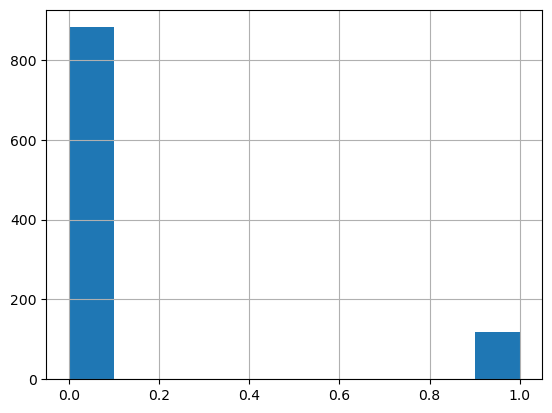

In [22]:
df_smal['toxic'].hist()
df_smal['toxic'].value_counts(normalize= True)

Соотношение классов аналогично генеральной совокупности.

In [23]:
sentences = df_smal.text.values
labels = df_smal.toxic.values

Загружаем модель и токенайзер.

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = False)

Посмотрим как выглядит текст в разной степени обработки.

In [25]:
print(' Original: ', sentences[0])
print()
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print()
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Welcome to Wikipedia. Have fun.

Tokenized:  ['welcome', 'to', 'wikipedia', '.', 'have', 'fun', '.']

Token IDs:  [6160, 2000, 16948, 1012, 2031, 4569, 1012]


Токенизируем и считаем их максимальное количество

In [26]:
max_len = 0
for sent in sentences:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (1336 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (725 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (756 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (775 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Max sentence length:  1613


Максимальное коичество токенов в одном тексте - 2501, максимальное количество которое пропускает Берт - 512, поэтому проведу токенизацию с уменьшение токенов до 510 (2 оставлю на открывающий и закрывающий).

In [27]:
input_ids = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent, 
                        add_special_tokens = True, 
                        max_length = 510,           
                   )
    
    input_ids.append(encoded_dict['input_ids'])

Token indices sequence length is longer than the specified maximum sequence length for this model (1336 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (725 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (756 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (775 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

In [28]:
max_len = 0
for i in input_ids:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in input_ids])
attention_mask = np.where(padded != 0, 1, 0)

In [29]:
print(np.array(padded).shape)
print(attention_mask.shape)

(1000, 510)
(1000, 510)


С размерами все хорошо, идем дальше.

Cоздаем эмбеддинги.

In [30]:
batch_size = 100
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

    with torch.no_grad(): 
        batch_embeddings = model(batch, attention_mask = attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].numpy()) 

features_bert = np.concatenate(embeddings)

  0%|          | 0/10 [00:00<?, ?it/s]

Делим нашу выборку на подвыборки для обучения, валидации и теста, в пропорции: 60/20/20

In [31]:
features_train_bert, features_tv_bert, target_train_bert, target_tv_bert = train_test_split(
    features_bert, labels, random_state=1234567, stratify = labels, test_size=0.4)

features_test_bert, features_valid_bert, target_test_bert, target_valid_bert = train_test_split(
    features_tv_bert, target_tv_bert, random_state=1234567, stratify= target_tv_bert, test_size=0.5)

In [32]:
model_bert = LogisticRegression(random_state=1234567, solver='lbfgs', class_weight = 'balanced')
model_bert.fit(features_train_bert, target_train_bert) 
predict_val_bert = model_bert.predict(features_valid_bert) 

In [33]:
f1_sc_bert = f1_score(target_valid_bert, predict_val_bert)
print("f1_score модели BERT:", f1_sc_bert.round(2))

f1_score модели BERT: 0.68


---

**Построим таблицу с результатами проведенного обучения**

In [34]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'BERT_2000']
data = {'F1 на валидации':[f1_sc.round(4),
                           best_f1_sc.round(4),
                           f1_sc_bert.round(4)],
}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Задача решена'] = scores_data['F1 на валидации'] > 0.75
scores_data

,F1 на валидации,Задача решена
LogisticRegression,0.7539,True
DecisionTreeClassifier,0.6029,False
BERT_2000,0.6809,False


**Вывод:** Наилучший результат и целевой показатель при валидации достигла только модель LogisticRegression. Ее и будем тестировать.

---

## Выводы

In [35]:
predict_val_test = model_lg.predict(features_test_tfidf)
f1_sc_test = f1_score(target_test, predict_val_test)
print("f1_score модели Логистическая регрессия на тесте:", f1_sc_test.round(4))

f1_score модели Логистическая регрессия на тесте: 0.7606


**Построим таблицу с итоговыми результатами**

In [36]:
t=0
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'BERT_2000']
data = {'F1 на валидации':[f1_sc.round(4),
                           best_f1_sc.round(4),
                           f1_sc_bert.round(4)],
        'F1 на тесте':[f1_sc_test.round(4),
                                       t,
                                       t]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Задача решена'] = scores_data['F1 на валидации'] > 0.75
scores_data

,F1 на валидации,F1 на тесте,Задача решена
LogisticRegression,0.7539,0.7606,True
DecisionTreeClassifier,0.6029,0.0000,False
BERT_2000,0.6809,0.0000,False


---

**ВЫВОД:**  
- Объем строк датафрейма 159 292.
- Дубликатов и пропусков нет.
- Дисбаланс классов - 90%(0)/10%(1)
- Проведена лемматицация теста в столбце text в столбец lemm_text.
- Слова векторизированы через TfidfVectorizer, удалены стоп слова.
- Выборка разделена на обучающую, валидационнную и тестовую в соотношении: 60/20/20. 
- Для модели BERT, данные были урезаны до 1000 строк, для экономии времени обучения.

По итогу обучения наилучший результат и целевой показатель при валидации достигла только модель LogisticRegression: F1- мера - 0,7539.

При тестировании модель LogisticRegression: F1- мера - 0,7606. Поставленная задача проекта выполнена.